In [1]:
import pandas as pd
import sklearn
import itertools
import numpy as np
import seaborn as sb
import re
import nltk
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [2]:
fake=pd.read_csv("Fake.csv")
true=pd.read_csv("True.csv")

In [3]:
fake.shape

(23481, 4)

In [4]:
true.shape

(21417, 4)

# Data cleaning and preparation

In [5]:
fake['target']='fake'
true['target']='true'

In [6]:
data=pd.concat([fake,true]).reset_index(drop=True)
data.shape

(44898, 5)

In [7]:
from sklearn.utils import shuffle
data=shuffle(data)
data=data.reset_index(drop=True)

In [8]:
data.head()

,title,text,subject,date,target
0,Latest Senate healthcare bill would leave 22 m...,WASHINGTON (Reuters) - The latest version of S...,politicsNews,"July 20, 2017",true
1,FIND OUT IF YOUR SENATOR VOTED TO HELP OBAMA W...,Remember Joni Ernst? Conservatives were so exc...,left-news,"Jun 23, 2015",fake
2,Myanmar forces may be guilty of genocide again...,GENEVA (Reuters) - Myanmar s security forces m...,worldnews,"December 5, 2017",true
3,Taiwan appoints new premier to drive reform ef...,TAIPEI (Reuters) - Taiwan has appointed as pre...,worldnews,"September 5, 2017",true
4,ANGRY BLACK MILWAUKEE RESIDENTS Set City On Fi...,This is Obama s America This will be his legac...,left-news,"Aug 14, 2016",fake


In [9]:
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,Latest Senate healthcare bill would leave 22 m...,WASHINGTON (Reuters) - The latest version of S...,politicsNews,true
1,FIND OUT IF YOUR SENATOR VOTED TO HELP OBAMA W...,Remember Joni Ernst? Conservatives were so exc...,left-news,fake
2,Myanmar forces may be guilty of genocide again...,GENEVA (Reuters) - Myanmar s security forces m...,worldnews,true
3,Taiwan appoints new premier to drive reform ef...,TAIPEI (Reuters) - Taiwan has appointed as pre...,worldnews,true
4,ANGRY BLACK MILWAUKEE RESIDENTS Set City On Fi...,This is Obama s America This will be his legac...,left-news,fake


In [10]:
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,WASHINGTON (Reuters) - The latest version of S...,politicsNews,true
1,Remember Joni Ernst? Conservatives were so exc...,left-news,fake
2,GENEVA (Reuters) - Myanmar s security forces m...,worldnews,true
3,TAIPEI (Reuters) - Taiwan has appointed as pre...,worldnews,true
4,This is Obama s America This will be his legac...,left-news,fake


In [11]:
data['text']=data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,washington (reuters) - the latest version of s...,politicsNews,true
1,remember joni ernst? conservatives were so exc...,left-news,fake
2,geneva (reuters) - myanmar s security forces m...,worldnews,true
3,taipei (reuters) - taiwan has appointed as pre...,worldnews,true
4,this is obama s america this will be his legac...,left-news,fake


In [12]:
#Remove punctuations
import string
def punctuation_removal(text):
    all_list=[char for char in text if char not in string.punctuation]
    clean_str=''.join(all_list)
    return clean_str
data['text']=data['text'].apply(punctuation_removal)

In [13]:
data.head()

,text,subject,target
0,washington reuters the latest version of sena...,politicsNews,true
1,remember joni ernst conservatives were so exci...,left-news,fake
2,geneva reuters myanmar s security forces may ...,worldnews,true
3,taipei reuters taiwan has appointed as premie...,worldnews,true
4,this is obama s america this will be his legac...,left-news,fake


In [15]:
#Removing stopwords
!Pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop=stopwords.words('english')
data['text']=data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Error loading stopwords: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


In [16]:
data.head()

,text,subject,target
0,washington reuters latest version senate repub...,politicsNews,true
1,remember joni ernst conservatives excited see ...,left-news,fake
2,geneva reuters myanmar security forces may gui...,worldnews,true
3,taipei reuters taiwan appointed premier willia...,worldnews,true
4,obama america legacy elected 90 black communit...,left-news,fake


# Basic data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


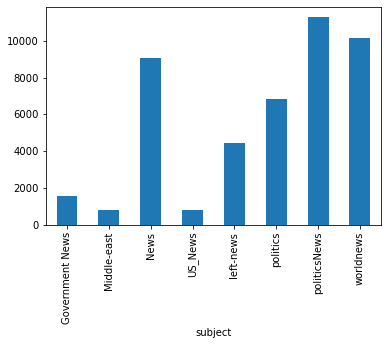

In [18]:
#How many articles per subject?
import matplotlib.pyplot as plt
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


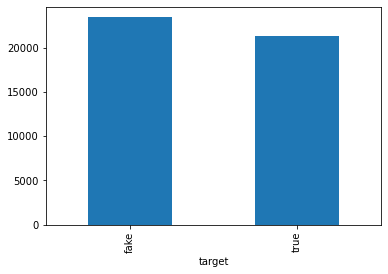

In [19]:
#How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

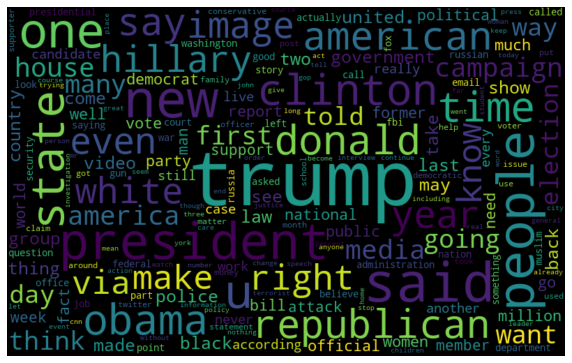

In [20]:
#word cloud for fake news
from wordcloud import WordCloud
fake_data=data[data["target"]=="fake"]
all_words=' '.join([text for text in fake_data.text])
wordcloud=WordCloud(width=800, height=500,
                   max_font_size=110,
                   collocations=False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

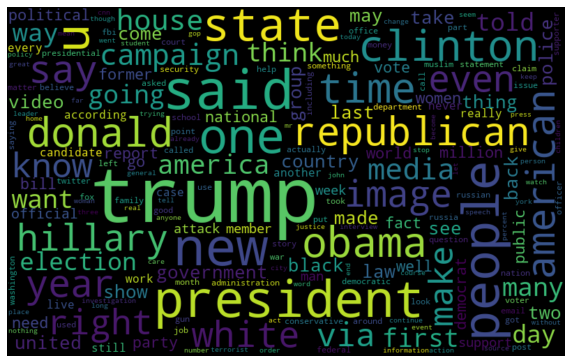

In [21]:
#word cloud for real news
from wordcloud import WordCloud
real_data=data[data["target"]=="true"]
all_words=' '.join([text for text in fake_data.text])
wordcloud=WordCloud(width=800, height=500,
                   max_font_size=110,
                   collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [27]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize
import seaborn as sns
token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

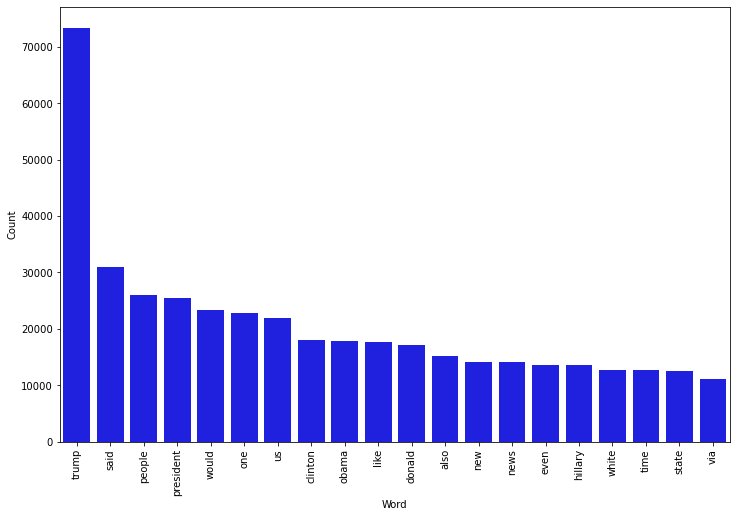

In [28]:
#Most frequent words in fake news
counter(data[data["target"] == "fake"],"text",20)

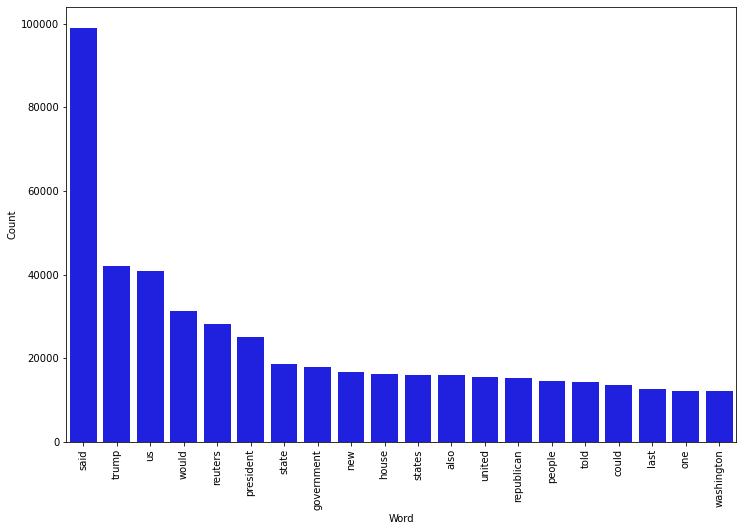

In [29]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

# Modeling

In [30]:
# Function to plot the confusion matrix
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Preparing the data

In [31]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

# Naive  Bayes

In [32]:
dct = dict()

from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

dct['Naive Bayes'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 95.32%


Confusion matrix, without normalization


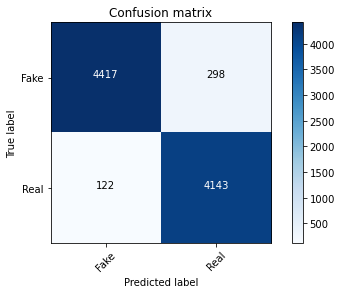

In [33]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# Logistic Regression

In [34]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Logistic Regression'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 98.81%


Confusion matrix, without normalization


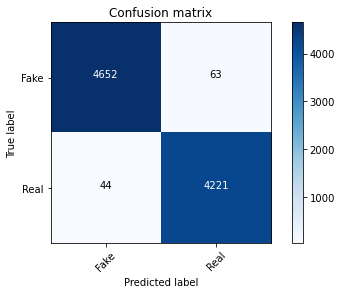

In [35]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# Decision Tree

In [36]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Decision Tree'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 99.62%


Confusion matrix, without normalization


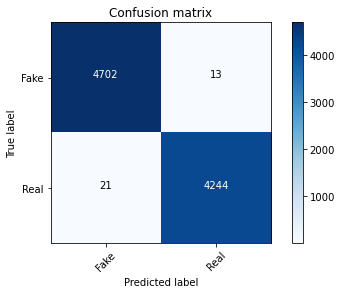

In [37]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Random Forest'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 99.14%


Confusion matrix, without normalization


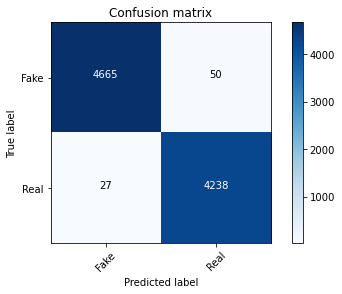

In [39]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# SVM

In [40]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', clf)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['SVM'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 99.49%


Confusion matrix, without normalization


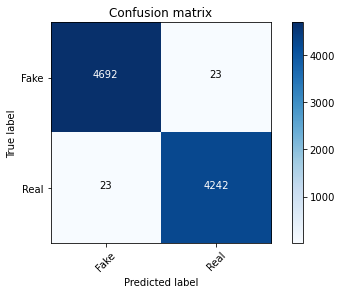

In [41]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# Comparing Different Models:

([<matplotlib.axis.YTick at 0x25584d408e0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

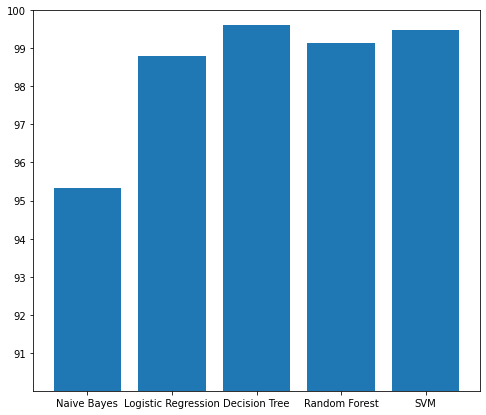

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,7))
plt.bar(list(dct.keys()),list(dct.values()))
plt.ylim(90,100)
plt.yticks((91, 92, 93, 94, 95, 96, 97, 98, 99, 100))

# Conclusion:

My final model is Decision Tree. The Accuracy of Decision Tree is 99.62%